<a href="https://colab.research.google.com/github/122Sandeep/DL_Model_Compression_Technique/blob/main/model_compression_Technique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://storage.googleapis.com/dlops-content/public/univailogo.jpeg" height="50px"> <a href='https://welcome.univ.ai/AcceleratedMasters/ai5-c1/' target='_blank'><strong><font color="#324bd9">AI-5: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#324bd9">Model Compression and Distillation</font>**

**Univ.AI**<br/>
**September 2022**<br/>
**Authors/Instructors:**<br/>
Pavlos Protopapas, Shivas Jayaram

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Installs**

In [ ]:
!pip install -q tensorflow_model_optimization

**Imports**

In [ ]:
import os
import requests
import tempfile
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
import random
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# TF Hub
import tensorflow_hub as hub

# TF Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

# sklearn
from sklearn.model_selection import train_test_split

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set the global random seed
tf.random.set_seed(215)
np.random.seed(215)
random.seed(215)

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Thu Sep  1 13:48:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    43W / 300W |    491MiB / 16160MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)
  
  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history, metrics=["loss","val_loss","accuracy","val_accuracy"]):
  for metric in metrics:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_model(model,test_data, model_train_history,execution_time, 
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results

## **<font color="#A41034">Knowledge Distillation</font>**



This exercise aims to distill a mobile-net model that has been trained initially on imagenet and then trained on nature images portraying weather patterns (sunny, cloudy, etc). The learned mobilenet-base model will be considered the "professor" network. We will use distillation techniques to train a smaller, less sophisticated network that will call a "student" network. The hope is that the wisdom from the professor network will be distilled and used. Good luck with that! 

## **<font color="#A41034">Weather Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/weather_data.zip", 
              base_path="dataset", extract=True)
download_file("https://github.com/dlops-io/models/releases/download/v1.0/distil_models.zip", 
              base_path="", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.3380936940511068


### **Load Data**

* Read-in data as lists
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [ ]:
# Load pre processed data
data_dir = "dataset/weather_data"

# Labels
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

Number of classes: 4
Labels: ['sunrise', 'rain', 'cloudy', 'shine']
data_x count: 1124
data_y count: 1124
['dataset/weather_data/sunrise/sunrise306.jpg', 'dataset/weather_data/sunrise/sunrise304.jpg', 'dataset/weather_data/sunrise/sunrise36.jpg', 'dataset/weather_data/sunrise/sunrise186.jpg', 'dataset/weather_data/sunrise/sunrise8.jpg']
['sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise']


### **View Images**

Let's take a look at the data.

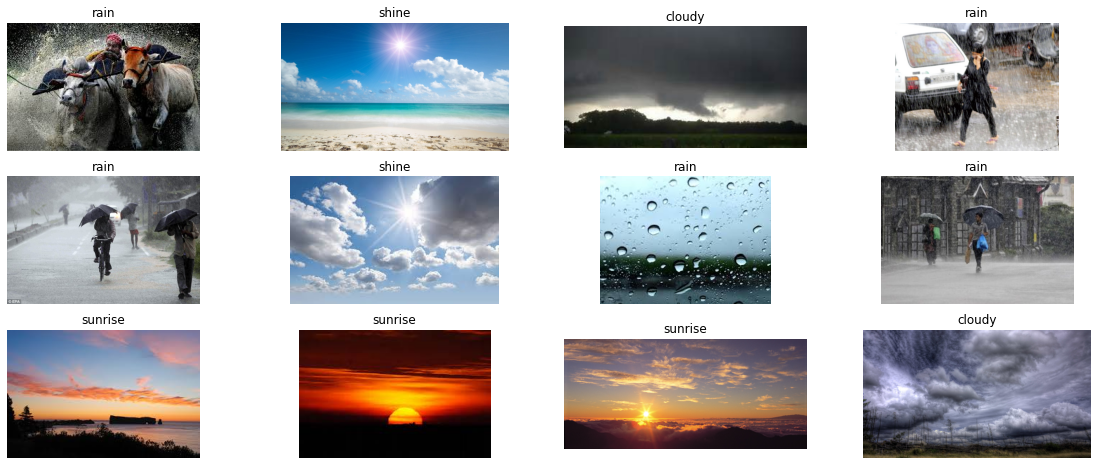

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_x)-1, size=12)

# View some images
fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_y[img_idx])
    # Read image
    image = cv2.imread(data_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()

## **<font color="#A41034">Build Data Pipelines</font>**

### **Split Data** 
We split data into train, validation

In [ ]:
validation_percent = 0.2

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 899
validate_x count: 225


### **Create TF Datasets**

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = 2
batch_size = 32
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size, seed=6767)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size, seed=8989)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## **<font color="#A41034">Build Teacher Model</font>**

#### **Teacher Model**

Teacher model is a mobilenet_v2 model which we get from directly from tfhub.

In [ ]:
def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=False),
        keras.layers.Dense(units=64, activation='relu',
                           kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                           bias_regularizer=keras.regularizers.l1(bias_weight)
                           ),
        keras.layers.Dense(units=num_classes,
                           kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                           bias_regularizer=keras.regularizers.l1(bias_weight)),
  ],name='teacher_model')

  return model

#### **Train Teacher**

Nothing magical about this step. We just train the teacher network. 

Model: "teacher_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2,340,228
Trainable params: 82,244
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/50
29/29 - 10s - loss: 56.5511 - sparse_categorical_accuracy: 0.2481 - val_loss: 55.9675 - val_sparse_categorical_accuracy: 0.3200 - 10s/epoch - 332ms/step
Epoch 2/50
29/29 - 4s - loss: 55.3477 - sparse_categorical_accuracy: 0.4093 - val_loss: 54.8274 - val_sparse_categorical_accuracy: 0.

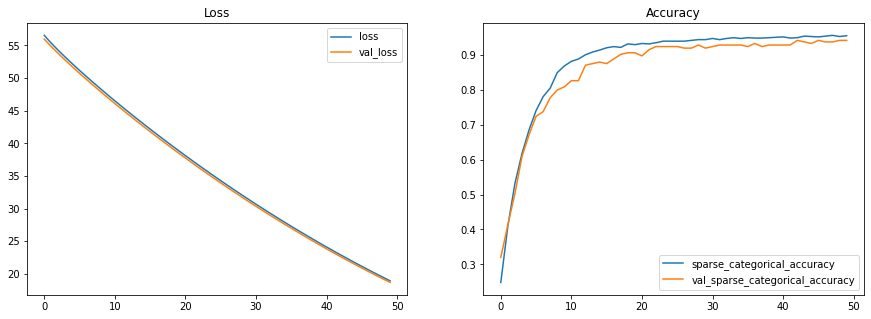

8/8 [==============================] - 1s 78ms/step - loss: 18.6927 - sparse_categorical_accuracy: 0.9422
{'loss': 18.692684173583984, 'sparse_categorical_accuracy': 0.9422222375869751}


[18.692684173583984, 0.9422222375869751]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 50

# Load pre trained model during demos
LOAD_PREV_TRAINED = False

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Build or Load Model
if not LOAD_PREV_TRAINED:
  # Build the teacher model
  teacher_model = build_teacher_model(image_height, image_width, num_channels, num_classes)
  print(teacher_model.summary())

  # Compile
  teacher_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])
  
else:
  # Load model
  teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  print(teacher_model.summary())


  with open("distil_models/teacher_model_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open("distil_models/teacher_model_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3 # Continue training for a few more epochs


# Train model
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=2)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,
                                             prev_training_history,
                                             metrics=["loss","val_loss","sparse_categorical_accuracy","val_sparse_categorical_accuracy"])
  execution_time = model_metrics["execution_time"] + execution_time

# Evaluate model
evaluate_model(teacher_model,validation_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

In [ ]:
#!zip -r models.zip models

## **<font color="#A41034">Build Student Model</font>**

#### **Student Model**

Student model is just 2 conv layers with max pooling and a dense layer

In [ ]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", 
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train Student from Scratch** 

We do this for for comparison purposes

Model: "student_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

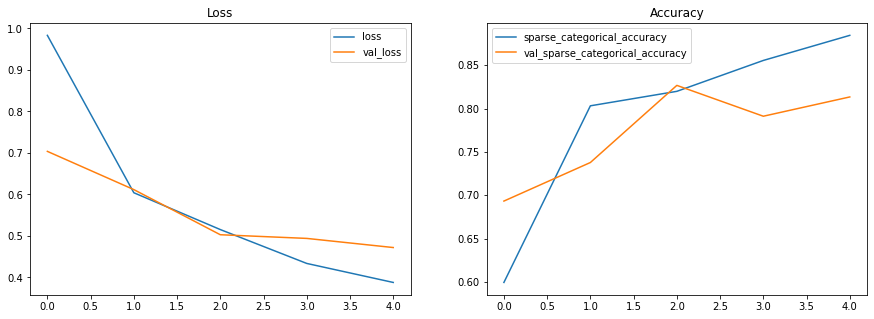

8/8 [==============================] - 1s 58ms/step - loss: 0.4718 - sparse_categorical_accuracy: 0.8133
{'loss': 0.471813827753067, 'sparse_categorical_accuracy': 0.8133333325386047}


[0.471813827753067, 0.8133333325386047]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time, 
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])



## **<font color="#A41034">Build Distiller</font>**

In [ ]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## **<font color="#A41034">Distill Teacher to Student</font>**

Model: "student_distill"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

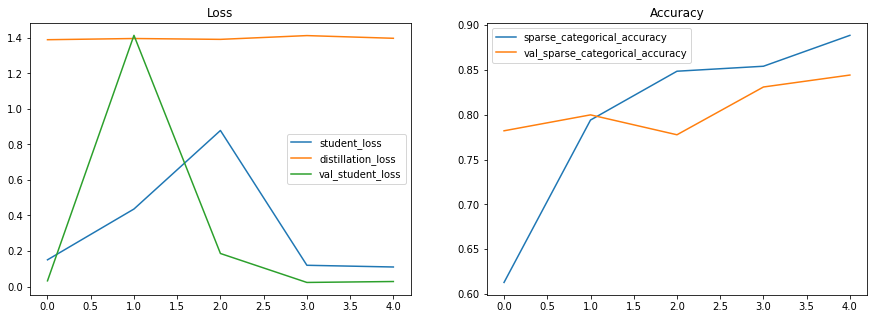

8/8 [==============================] - 1s 69ms/step - sparse_categorical_accuracy: 0.8444 - student_loss: 0.3865


{'sparse_categorical_accuracy': 0.8444444537162781, 'student_loss': 0.3158242106437683}


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5
Lambda = 0.75
temperature= 12

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data, 
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

# Save student model
save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)

## **<font color="#A41034">Compare All Models</font>**

In [ ]:
models_folder = "models" # distil_models / models 
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"82,244",4.04 mins,18.69,94.22%,9.615 MB,0.001,32,50,SGD,teacher_model
1,"13,940",0.40 mins,0.32,84.44%,0.078 MB,0.001,32,5,Adam,student_distill
3,"13,940",0.34 mins,0.47,81.33%,0.210 MB,0.001,32,5,Adam,student_scratch
2,"13,940",0.40 mins,0.51,80.00%,0.210 MB,0.010,32,5,Adam,before_prune


## **<font color="#A41034">Pruning</font>**

We can compress a model by model pruning. Pruning is where we set the weights of a network connection to zero for those which have a very small value. This can help reduce the size of the model

#### **Train Model from Scratch**

Model: "before_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                  

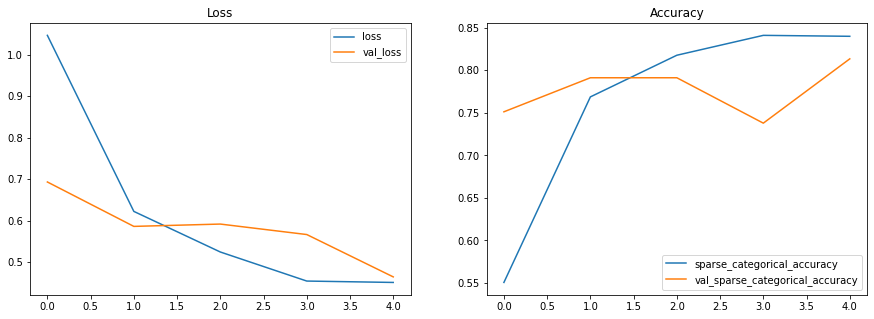

8/8 [==============================] - 1s 69ms/step - loss: 0.4718 - sparse_categorical_accuracy: 0.8133
{'loss': 0.4718138575553894, 'sparse_categorical_accuracy': 0.8133333325386047}


[0.4718138575553894, 0.8133333325386047]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
before_prune = build_student_model(image_height, image_width, num_channels, num_classes, model_name='before_prune')
print(before_prune.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
before_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train model
start_time = time.time()
training_results = before_prune.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time, 
               learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

#### **Analyze Model Weights**

Check how many weigths are zero. Usually most weights in a network have a very small values but are not zero.

In [ ]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(np.abs(w) <= 0.0001) / w.size * 100,6),"%")

check_model_weights(before_prune)

conv2d/kernel:0 Total: 216 Zeros: 0.0 %
conv2d/bias:0 Total: 8 Zeros: 0.0 %
conv2d_1/kernel:0 Total: 1152 Zeros: 0.0 %
conv2d_1/bias:0 Total: 16 Zeros: 0.0 %
dense/kernel:0 Total: 12544 Zeros: 0.135523 %
dense/bias:0 Total: 4 Zeros: 0.0 %


#### **Model Size on Disk**

A simple way to ship models is to `zip` the model file. If we `zip` the model before pruning we see that there is not much difference.

In [ ]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  print("Model before zip: %.2f Kb"% (os.path.getsize(model_file) / float(1000)))
  print("Model after zip: %.2f Kb"% (os.path.getsize(zip3) / float(1000)))


In [ ]:
compare_model_sizes(before_prune)

Model before zip: 77.53 Kb
Model after zip: 54.67 Kb


#### **Prune Model**

Now we use the tf optimization library to prune our model

In [ ]:
# Define model for pruning
epochs = 5
end_step = np.ceil(len(train_x) / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(before_prune, **pruning_params)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

model_for_pruning.summary()

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "before_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 112, 112, 8)      442       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_leaky_r  (None, 112, 112, 8)      1         
 e_lu (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_max_poo  (None, 56, 56, 8)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 28, 28, 16)       2322      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_leaky_r  (None, 28, 28, 16)      

#### **Analyze Pruned Weights**

In [ ]:
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

check_model_weights(after_prune)

Model: "before_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                  

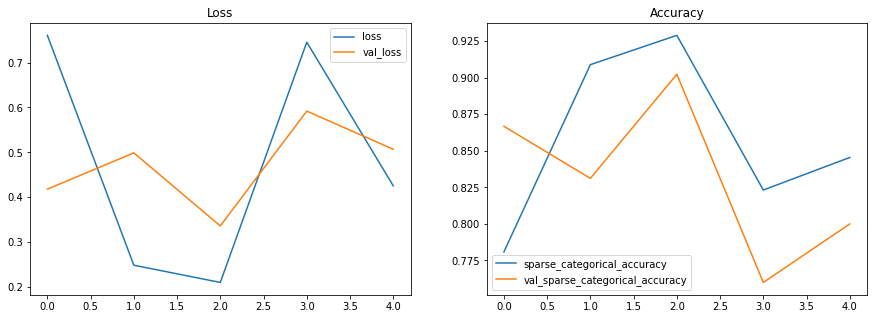

8/8 [==============================] - 1s 69ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.8000
{'loss': 0.5068492889404297, 'sparse_categorical_accuracy': 0.800000011920929}


[0.5068492889404297, 0.800000011920929]

In [ ]:
# Get model training history
training_history = training_results.history

# Compile
after_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Evaluate model
evaluate_model(after_prune,validation_data, training_history,execution_time, 
               learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

#### **Model Size on Disk after Pruning**

Now if we `zip` our model after pruning we see a significant reduction in size.

In [ ]:
compare_model_sizes(after_prune)

Model before zip: 77.53 Kb
Model after zip: 18.86 Kb
